# The Battle of Neighborhoods (Week four, Part I)

### Description of the Problem:

#### We are a company which is searching for the right neighborhood for private people and companies to settle. One contractor is a single guy after his studies to find a new flat. He wants to live in a neighborhood which is fun. This means bars, clubs and restaurants should be easily available. But the rental prices should be moderate at maximum.

### Packages

In [1]:
# importing standard libraries
import pandas as pd
import numpy as np

import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# library to handle requests
import requests

#!conda install -c conda-forge geopy --yes # uncomment this line if geopy is not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Import done!')

Import done!


### Import Zipcodes

In [55]:
# source: https://github.com/zauberware/postal-codes-json-xml-csv/blob/master/data/DE/zipcodes.de.csv - by simonfranzen on github
zipcodes = pd.read_csv('zipcodes.csv')
zipcodes = zipcodes[['zipcode', 'state', 'latitude','longitude']]
zipcodes_berlin = zipcodes[zipcodes['state'] == 'Berlin']
zipcodes_berlin.reset_index(drop = True, inplace = True)

# Drop certain zipcodes (e.g. 11011 is the German Bundestag)
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 11011]
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 13047]
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 14053]
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 14131]

### Import Venue Data

In [1]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ...
CLIENT_SECRET:...


In [57]:
#function to retrieve first 100 avenues per ZIP-code in Berlin and Hamburg
LIMIT = 100

def getNearbyVenues(zipcode, state, latitudes, longitudes, radius=1000):
    venues_list=[]
    print('Venue data is downloading...')
    for zipcode, state, lat, lng in zip(zipcode, state, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            state,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode',
                  'State',
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Venue data downloaded.')
    return(nearby_venues)

In [58]:
#run the above function on each neighborhood and create a new dataframe called venues_berlin
venues_berlin = getNearbyVenues(zipcode = zipcodes_berlin['zipcode'],
                                   state = zipcodes_berlin['state'],
                                   latitudes = zipcodes_berlin['latitude'],
                                   longitudes = zipcodes_berlin['longitude']
                                  )

Venue data is downloading...
Venue data downloaded.


### Inspect Venue Data

In [59]:
#Venues in Berlin and Hamburg data frame overview
print(f'Shape: {venues_berlin.shape}')
venues_berlin_clean = venues_berlin.copy()
venues_berlin_clean.drop_duplicates('Venue', keep='first', inplace=True)
venues_berlin_clean.sort_values(by = 'Zipcode', inplace = True)
print(f'Shape: {venues_berlin_clean.shape}')
venues_berlin_clean.reset_index([0], drop = True, inplace = True)
unique_venues = venues_berlin_clean['Venue Category'].nunique()
print(f'Total number of venues: {venues_berlin_clean.shape[0]}')
print(f'Total number of venue categories: {unique_venues}')

Shape: (9259, 8)
Shape: (5249, 8)
Total number of venues: 5249
Total number of venue categories: 399


### Prepare for Clustering

In [60]:
venues_berlin_clean.groupby(['Zipcode'],as_index = False).count().head()

,Zipcode,State,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,99,99,99,99,99,99,99
1,10117,92,92,92,92,92,92,92
2,10119,91,91,91,91,91,91,91
3,10178,73,73,73,73,73,73,73
4,10179,78,78,78,78,78,78,78


### Onehot Encoding for each Zipcode

In [61]:
onehot = pd.get_dummies(venues_berlin_clean[['Venue Category']], prefix="", prefix_sep="")

# add ZIP-code and state column back to dataframe
onehot['Zipcode'] = venues_berlin_clean['Zipcode']
onehot['State'] = venues_berlin_clean['State']

# move ZIP-code and State column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
onehot.reset_index([0], drop = True, inplace = True)

print(f'Shape: {onehot.shape}')
onehot.head()

Shape: (5249, 401)


,Zipcode,State,ATM,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Import the rental prices of Berlin

In [62]:
# Source: https://www.miet-check.de
rental_prices = pd.read_csv('mietspiegel.csv', sep = ';')
rental_prices.head()

,Zipcode,Price
0,10115,22.28
1,10117,20.20
2,10119,21.38
3,10178,16.66
4,10179,22.82


### Describing the Data

(25, 2)


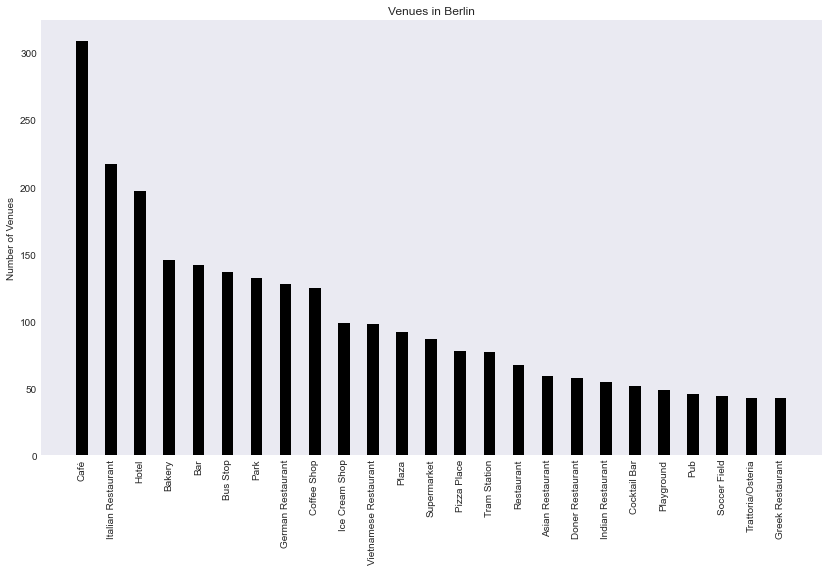

In [63]:
#select plotting style
#print(plt.style.available)
mpl.style.use(['seaborn-dark'])

# counting returned venues per city
venue_count = onehot.groupby('State').sum().reset_index()
venue_count.drop('Zipcode', axis = 1, inplace = True)
venue_count = venue_count.set_index('State').transpose()
venue_count['Total'] = venue_count.sum(axis=1)
venue_count.sort_values(by = ['Total'], inplace = True, ascending = False)

#filter for top 25 venues and sort
venue_count_top25 = venue_count.head(25)
print(venue_count_top25.shape)
venue_count_top25.reset_index(inplace = True)
venue_count_top25.columns = ['Venue', 'Berlin', 'Total']

#visualize top 25 venues
X = np.arange(25)
width = 0.4

plt.figure(figsize=(14,8), facecolor = 'white')

plt.bar(X + 0.20, venue_count_top25['Berlin'], color = '#000000', width = width)

plt.ylabel('Number of Venues')
plt.title('Venues in Berlin')

plt.xticks(X + width / 2, venue_count_top25['Venue'], rotation='vertical')

plt.show()

In [70]:
# Functions to add the median value 
# Source: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value

def add_median_labels(ax, precision='.1f'):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{precision}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

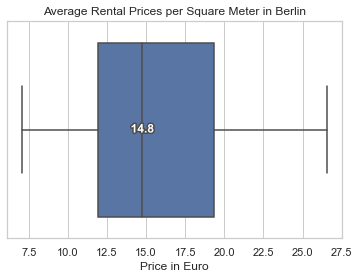

In [76]:
# Boxplot of rental prices:
sns.set_theme(style="whitegrid")

rental_prices_boxplot = sns.boxplot(x=rental_prices["Price"])
add_median_labels(rental_prices_boxplot.axes)

rental_prices_boxplot.set_title('Average Rental Prices per Square Meter in Berlin')
rental_prices_boxplot.set_xlabel('Price in Euro')

plt.show()